# Applications of Machine Learning - Coursework Submission - Notebook for Classifier Model
### Steven Dillmann

**MPhil Data Intensive Science | University of Cambridge**

28th March 2024

[sd2022@cam.ac.uk](sd2022@cam.ac.uk)

This notebook was written by Steven Dillmann as part of the coursework submission for the *Applications of Machine Learning* module in the MPhil in Data Intensive Science at the University of Cambridge. The coursework assignment can be found here: [Applications of Machine Learning - Coursework Assignment](../coursework.pdf). The associated report can be found here: [Applications of Machine Learning - Coursework Report](../report/m2_sd2022_report.pdf).

## Set-Up

### Installations & Imports and Settings

In [14]:
# !mkdir -p contents
!pip install pandas
!pip install numpy
!pip intall typing
!pip install torch
!pip install accelerate
!pip install torchvision
!pip install tqdm
!pip install ipykernel
!pip install ipython
!pip install scikit-learn
from typing import Dict, Tuple
import numpy as np
import torch
import torch.nn as nn
from accelerate import Accelerator
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import optim
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
import pandas as pd
import shutil

ERROR: unknown command "intall" - maybe you meant "install"
  Using cached scikit_learn-1.4.1.post1-cp311-cp311-macosx_10_9_x86_64.whl.metadata (11 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.4.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 6.3 MB/s eta 0:00:0000:0100:01
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Using cached threadpoolctl-3.4.0-py3-none-any.whl (17 kB)


mps
torch.Size([128, 1, 28, 28]) torch.Size([128])


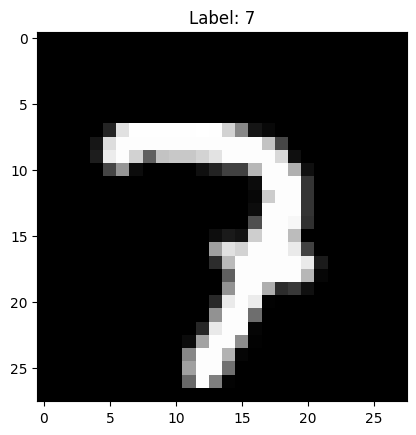

In [19]:
# Check for MPS (Apple Silicon) availability
if torch.backends.mps.is_available():
    device = torch.device('mps')
# Default to CPU if neither CUDA nor MPS is available
else:
    device = torch.device('cpu')
print(device)

# Load the full dataset
full_dataset = datasets.MNIST(root='../data_classifier', download=True, transform=ToTensor())

# Split the dataset into training and test sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
test_size = len(full_dataset) - train_size  # 20% for testing

train_data, test_data = random_split(full_dataset, [train_size, test_size])

# Create DataLoader instances for training and testing
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

for data, target in train_loader:
    print(data.size(), target.size())
    # Example of plotting the first image in the batch
    plt.imshow(data[0].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {target[0]}')
    plt.show()
    break  # Remove break to iterate through more batches



In [13]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)

# Define the loss function 
loss_func = nn.CrossEntropyLoss()   
loss_func
# Use Adam as the optimizer
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)   
optimizer

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [20]:
def train(num_epochs, cnn, train_loader, loss_func, optimizer, device):
    cnn.train()
    cnn.to(device)
    
    for epoch in range(num_epochs):
        total_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = cnn(images)[0]
            loss = loss_func(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}')

# Call the train function
epochs = 20
losses = train(epochs, cnn, train_loader, loss_func, optimizer, device)



Epoch [1/20], Step [100/375], Loss: 0.0279
Epoch [1/20], Step [200/375], Loss: 0.0409
Epoch [1/20], Step [300/375], Loss: 0.0133
Epoch [1/20] Average Loss: 0.0221
Epoch [2/20], Step [100/375], Loss: 0.0169
Epoch [2/20], Step [200/375], Loss: 0.0159
Epoch [2/20], Step [300/375], Loss: 0.0015
Epoch [2/20] Average Loss: 0.0168
Epoch [3/20], Step [100/375], Loss: 0.0021
Epoch [3/20], Step [200/375], Loss: 0.0130
Epoch [3/20], Step [300/375], Loss: 0.0035
Epoch [3/20] Average Loss: 0.0132
Epoch [4/20], Step [100/375], Loss: 0.0039
Epoch [4/20], Step [200/375], Loss: 0.0128
Epoch [4/20], Step [300/375], Loss: 0.0040
Epoch [4/20] Average Loss: 0.0119
Epoch [5/20], Step [100/375], Loss: 0.0068
Epoch [5/20], Step [200/375], Loss: 0.0011
Epoch [5/20], Step [300/375], Loss: 0.0073
Epoch [5/20] Average Loss: 0.0096
Epoch [6/20], Step [100/375], Loss: 0.0053
Epoch [6/20], Step [200/375], Loss: 0.0060
Epoch [6/20], Step [300/375], Loss: 0.0339
Epoch [6/20] Average Loss: 0.0090
Epoch [7/20], Step [10

In [21]:
def test(cnn, test_loader, device):
    cnn.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Temporarily set all the requires_grad flag to false
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move to the correct device
            test_output, _ = cnn(images)  # Forward pass
            pred_y = torch.max(test_output, 1)[1]  # Get the predicted class (the index of the max log-probability)
            correct += (pred_y == labels).sum().item()
            total += labels.size(0)
        
        accuracy = 100 * correct / total
        print(f'Test Accuracy of the model on the 10000 test images: {accuracy:.2f}%')

# Assuming 'device' is defined (either 'cuda', 'mps', or 'cpu')
# Assuming 'test_loader' is defined and holds your DataLoader for the test dataset
test(cnn, test_loader, device)


Test Accuracy of the model on the 10000 test images: 98.74%


In [18]:
# Save the model 
torch.save(cnn.state_dict(), '../classifier_models/cnn_classifier5.pth')